In [80]:
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from math import pi,sin,cos,acos,asin
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import math
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import minimize
from matplotlib.ticker import PercentFormatter
from scipy.optimize import fsolve
import matplotlib.ticker as ticker

In [81]:
def cosd(b):
    return cos(math.radians(b))
def sind(a):
    return sin(math.radians(a))
def tand(f):
    return tan(math.radians(f))
def acosd(d):
    return math.degrees(acos(d))
def asind(c):
    return math.degrees(asin(c))

In [82]:
df = pd.read_csv (r"D:\USTH\DLR\data\forecast data\singlestep_datasheet_with DLR.csv")  
df['UT_Time']= df.datetime.apply(lambda x: datetime.strptime(x,'%m/%d/%Y %H:%M'))
df['LocalTime'] = df['UT_Time']


In [83]:
time = np.array(df.LocalTime)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


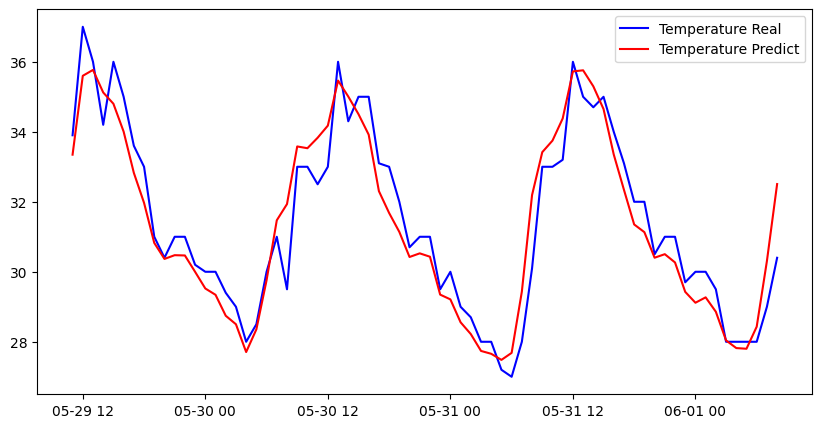

In [84]:
fig,ax= plt.subplots(figsize= (10,5))

plt.plot(time, df.temp_real, linewidth = 1.5, label = 'Temperature Real', color = 'b')
plt.plot(time, df.temp_pre, linewidth = 1.5, label = 'Temperature Predict', color = 'r')
plt.legend(loc = 'upper right', fontsize=10)

plt.savefig(r"D:\USTH\DLR\image\Temp_plot.eps", format='eps', dpi=1500)
plt.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


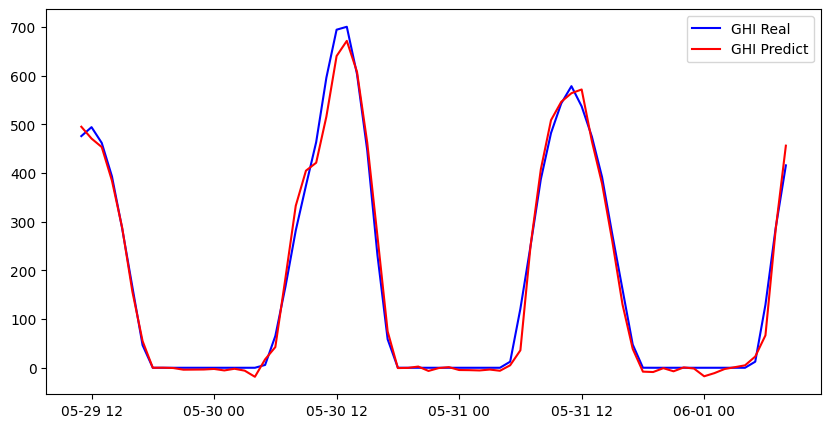

In [85]:
fig,ax= plt.subplots(figsize= (10,5))

plt.plot(time, df.GHI_real, linewidth = 1.5, label = 'GHI Real', color = 'b')
plt.plot(time, df.GHI_pre, linewidth = 1.5, label = 'GHI Predict', color = 'r')
plt.legend(loc = 'upper right', fontsize=10)
plt.savefig(r"D:\USTH\DLR\image\GHI_plot.eps", format='eps', dpi=1500)
plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


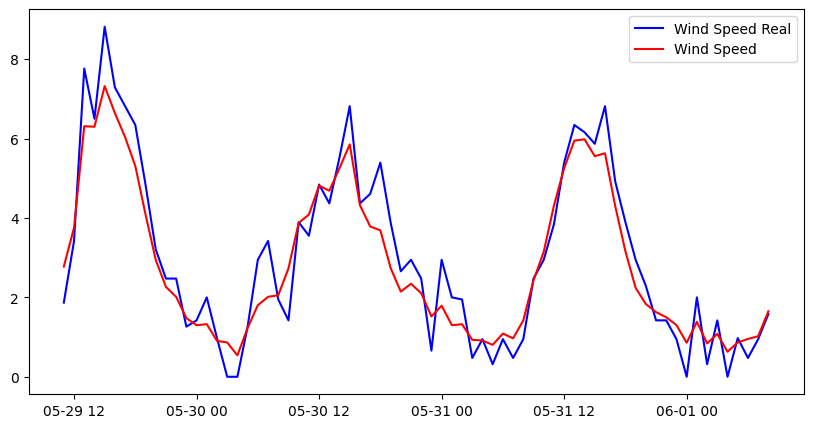

In [86]:
fig,ax= plt.subplots(figsize= (10,5))

plt.plot(time, df.Wind_real, linewidth = 1.5, label = 'Wind Speed Real', color = 'b')
plt.plot(time, df.Wind_pre, linewidth = 1.5, label = 'Wind Speed', color = 'r')
plt.legend(loc = 'upper right', fontsize=10)
plt.savefig(r"D:\USTH\DLR\image\Wind_plot.eps", format='eps', dpi=1500)
plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


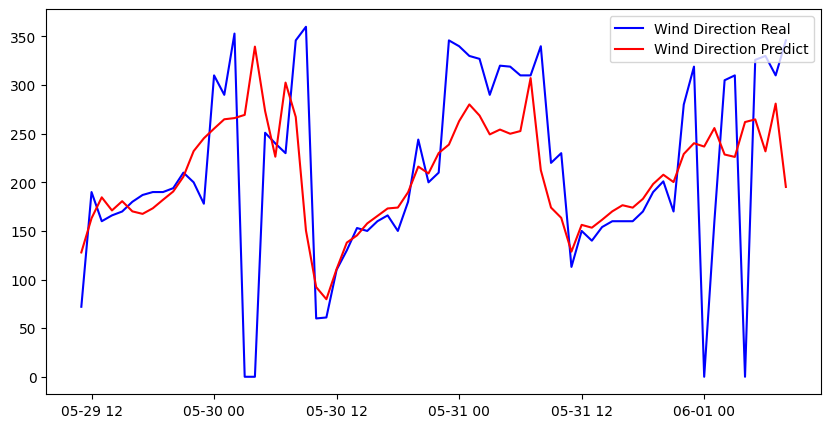

In [87]:
fig,ax= plt.subplots(figsize= (10,5))

plt.plot(time, df.WinDir_real, linewidth = 1.5, label = 'Wind Direction Real', color = 'b')
plt.plot(time, df.WinDir_pre, linewidth = 1.5, label = 'Wind Direction Predict', color = 'r')
plt.legend(loc = 'upper right', fontsize=10)
plt.savefig(r"D:\USTH\DLR\image\Windir_plot.eps", format='eps', dpi=1500)
plt.show()



In [88]:
def wind(x):
    if abs(205.46-x) <= 90:
        return abs(205.46-x)
    elif abs(205.46-x) > 90:
        return (abs(180-abs(205.46-x)))
    else:
        return 0

In [89]:
df['WindDirection']= df.WinDir_real.apply(lambda x: abs(205.46-x) 
                           if abs(205.46-x) <= 90 
                           else (abs(180-abs(205.46-x)) if abs(205.46-x) > 90 else 0))
Wd=np.array(df.WindDirection)

In [90]:
Ts = 100 # maximum allowable Temp
def Re(Ta,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0224 # Conductor diameter
    He = 20 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    return Do*p*Wv/u

In [91]:
def Qc(Ta,Wd,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0224 # Conductor diameter
    He = 20 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*(10**(-6))*((Tf+273)**1.5))/(Tf+383.4) # dynamic viscosity of air
    # Wv = # wind velocity
    
    #Wd = 90 # angle of wind direction and conductor axis
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    q1= K*(1.01+1.35*(Re(Ta,Wv)**0.52))*kf*(Ts-Ta) #1.35 w/m correct at low wind speeds
    q2= K*0.754*(Re(Ta,Wv)**0.6)*kf*(Ts-Ta)  #0.754 w/m correct at high wind speeds
    # Choose the larger of (q1,q2)
    q3 = 3.645*(p**0.5)*(Do**0.75)*((Ts-Ta)**1.25) # 3.645 at low Wv use the larger of forced and natural
    
    if Wv <= 0.2:
        return max(q1,q2,q3)
    else:
        return max(q1,q2)

In [92]:
def Qr(Ta):
    Do = 0.0224
    Ts=100
    e = 0.7# emissivity
    return 17.8*Do*e*(1/10**8)*((Ts+273)**4-(Ta+273)**4)

In [93]:
a = 0.9 # absorbsibility
Do = 0.0224 # Conductor diameter
def Qs(qs):
    return a*Do*qs

In [94]:
def R(Ta): 
    R_low = 0.0983/1609.344
    R_high = 0.117/1609.344
    T_low = 25
    T_high = 75
    Ts =100
    Tf =0.5*(Ts+Ta)
    return R_low + (R_high-R_low)*(Tf-T_low)/(T_high-T_low)+R_low

In [95]:
def Re_CI(Ta,Wv):
    Tf=0.5*(Ta+Ts)
    #Ts = 100 # maximum allowable Temp
    L=2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #lamda #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#muy #dynamic viscosity of air
    He = 20 # elevation
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#gamma#density of air
    return Do*g*Wv/m

In [96]:
def Re_CI(Ta,Wv):
    Tf=0.5*(Ta+Ts)
    #Ts = 100 # maximum allowable Temp
    L=2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #lamda #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#muy #dynamic viscosity of air
    He = 10 # elevation
    u = (1.458*10**(-6)*(Tf+273)**1.5)/(Tf+383.4) # dynamic viscosity of air
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#gamma#density of air
    return Do*g*Wv/m

In [97]:
def Cf(Ta):
    Tf = 0.5*(Ts+Ta)
    M_s = 329*0.45359237/(1000*0.3048)
    M_a = 899*0.45359237/(1000*0.3048)
    M = 1228*0.45359237/(1000*0.3048)
    C_steel = 481*(1+10**(-4)*(Tf-20))
    C_alum = 897*(1+3.8*10**(-4)*(Tf-20))
    return (C_steel*M_s + C_alum*M_a)/M

In [98]:
def Nu_90(Ta,Wv):
    if (Re_CI(Ta,Wv)>=100) and (Re_CI(Ta,Wv)<2650):
        return 0.641*Re_CI(Ta,Wv)**0.471
    elif (Re_CI(Ta,Wv)>=2650) and (Re_CI(Ta,Wv)<50000):
        return 0.048*Re_CI(Ta,Wv)**0.8
    else:
        return 0

In [99]:
def Nu(Ta,Wv,Wd):
    if (Wd <=24 and Wd >0):
        return Nu_90(Ta,Wv)*(0.42+0.68*(sind(Wd))**1.08)
    if (Wd >24 and Wd <90):
        return Nu_90(Ta,Wv)*(0.42+0.58*(sind(Wd))**0.9)
    else:
        return 0

In [100]:
def Nu_nat(Ta,Wv,Wd):
    Do = 0.0224
    Tf = 0.5*(Ta+Ts)
    L = 2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#dynamic viscosity of air
    He =10 # elevation
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#density of air     
    Gr = Do**3*(Ts-Ta)*10/((Tf+273)*(m/g))
    Pr = Cf(Tf)*m/L
    if ((Gr*Pr)>10**(-1))and((Gr*Pr)<10**2):
        return 1.02*(Gr*Pr)**0.148
    elif ((Gr*Pr)>10**(2))and((Gr*Pr)<10**4):
        return 0.850*(Gr*Pr)**0.188
    elif ((Gr*Pr)>10**(4))and((Gr*Pr)<10**7):
        return 0.480*(Gr*Pr)**0.250
    elif ((Gr*Pr)>10**(7))and((Gr*Pr)<10**12):
        return 0.125*(Gr*Pr)**0.333
    else:
        return 0

In [101]:
def Qc_CI(Ta,Wv,Wd):
    Ts = 100 # maximum allowable Temp
    Do = 0.0224
    Tf = 0.5*(Ta+Ts)
    L = 2.368*10**(-2)+7.23*10**(-5)*Tf-2.763*10**(-8)*Tf**2 #thermal conductivity of air
    m = (17.239+4.635*10**(-2)*Tf-2.03*10**(-5)*Tf**2)*10**(-6)#dynamic viscosity of air
    He =10 # elevation
    g = (1.293-1.525*10**(-4)*He+6.379*10**(-9)*He**2)/(1+0.00367*Tf)#density of air
    Pc_force = (Nu(Ta,Wv,Wd))*pi*L*(Ts-Ta)
    Pc_nat = Nu_nat(Ta,Wv,Wd)*pi*L*(Ts-Ta)
    #if Wv <=0.5:
      #  return Pc_nat
    #else:
    return max(Pc_force,Pc_nat)

In [102]:
def I_CI(Ta,qs,Wv,Wd):
    return math.sqrt((Qc_CI(Ta,Wv,Wd)+Qr(Ta)-Qs(qs))/R(Ta))

In [103]:
Ta_tol = np.array(df.temp_real) #ambientTemp
Wv_tol = np.array(df.Wind_real) #windVelocity #[(df.Month.isin([m]))&(df['Day']<32)]
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs_tol = np.array(df.GHI_real) #solarIrradiance
df['WindDirection']= df.WinDir_real.apply(lambda x: abs(205.46-x) 
                           if abs(205.46-x) <= 90 
                           else (abs(180-abs(205.46-x)) if abs(205.46-x) > 90 else 0))
Wd_tol=np.array(df.WindDirection)

In [104]:
def eff_wind(Ta,Wd,Wv):
    #Ta = 25 # ambient temp
    Ts = 100 # maximum allowable Temp
    Tf = (Ts+Ta)/2 # temp of boundary layer
    Do = 0.0224 # Conductor diameter
    He = 20 # elevation
    p = (1.293-1.525*10**(-4)*He + 6.379*10**(-9)*He**2)/(1+0.00367*Tf) # air density
    u = (1.458*(10**(-6))*((Tf+273)**1.5))/(Tf+383.4) # dynamic viscosity of air
    #Do*p*Wv/u
    # Wv = # wind velocity
    #Wd = 90 # angle of wind direction and conductor axis
    kf = 2.424*10**(-2)+7.477*10**(-5)*Tf - 4.407*10**(-9)*Tf**2 # thermal conductivity of air
    K = 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd) #wind direction factor
    q1= K*(1.01+1.35*(Re(Ta,Wv)**0.52))*kf*(Ts-Ta) #1.35 w/m correct at low wind speeds
    q2= K*0.754*(Re(Ta,Wv)**0.6)*kf*(Ts-Ta)  #0.754 w/m correct at high wind speeds
    # Choose the larger of (q1,q2)
    q3 = 3.645*(p**0.5)*(Do**0.75)*((Ts-Ta)**1.25) # 3.645 at low Wv use the larger of forced and natural   
    
    if q1>q2:
        return (((K_a(Wd)*(1.01+1.35*(Re(Ta,Wv)**0.52))/K_a(90)-1.01)/1.35)**(1/0.52))*u/(Do*p)
    else:
        return ((K_a(Wd)*(Re(Ta,Wv)**0.6)/K_a(90))**(1/0.6))*u/(Do*p)

In [105]:
def K_a(Wd):
    return 1.194-cosd(Wd)+0.194*cosd(2*Wd)+0.368*sind(2*Wd)

In [106]:
def I_3E(Ta,qs,Wv,Wd):
    return math.sqrt((Qc(Ta,Wd,Wv)+Qr(Ta)-Qs(qs))/R(Ta))
#Time = np.array(df.LocalTime[(df['Month']==m)&(df['Day']<15)])

In [107]:
m = 6
n =7
time = np.array(df.LocalTime)
Ta = np.array(df.temp_real) #ambientTemp
Wv = np.array(df.Wind_real) #windVelocity #[(df.Month.isin([m]))&(df['Day']<32)]
#Wd_northbase = np.array(df.WindDir_Wvane1_deg_avg360) #windDirection
qs = np.array(df.GHI_real) #solarIrradiance
df['WindDirection']= df.WinDir_real.apply(lambda x: abs(205.46-x) 
                           if abs(205.46-x) <= 90 
                           else (abs(180-abs(205.46-x)) if abs(205.46-x) > 90 else 0))
Wd=np.array(df.WindDirection)

In [108]:
Wve = np.array([eff_wind(Ta[i], Wd[i], Wv[i]) for i in range(len(Ta))])


C:\Users\minhk\AppData\Local\Temp\ipykernel_5752\2244183191.py:20: RuntimeWarning: invalid value encountered in double_scalars
  return (((K_a(Wd)*(1.01+1.35*(Re(Ta,Wv)**0.52))/K_a(90)-1.01)/1.35)**(1/0.52))*u/(Do*p)


In [109]:
I_CI(25,1000,5,90)
amp_plot =np.array([I_3E(Ta[i], qs[i], Wv[i], Wd[i]) for i in range(len(Ta))])
amp_plot_CI =np.array([I_CI(Ta[i], qs[i], Wv[i], Wd[i]) for i in range(len(Ta))])
Nu_plot = np.array([Nu(Ta[i], Wv[i], Wd[i]) for i in range(len(Wd))])
for (i, val) in enumerate(amp_plot):
    if (i==130020):
        print(i, val)
#420


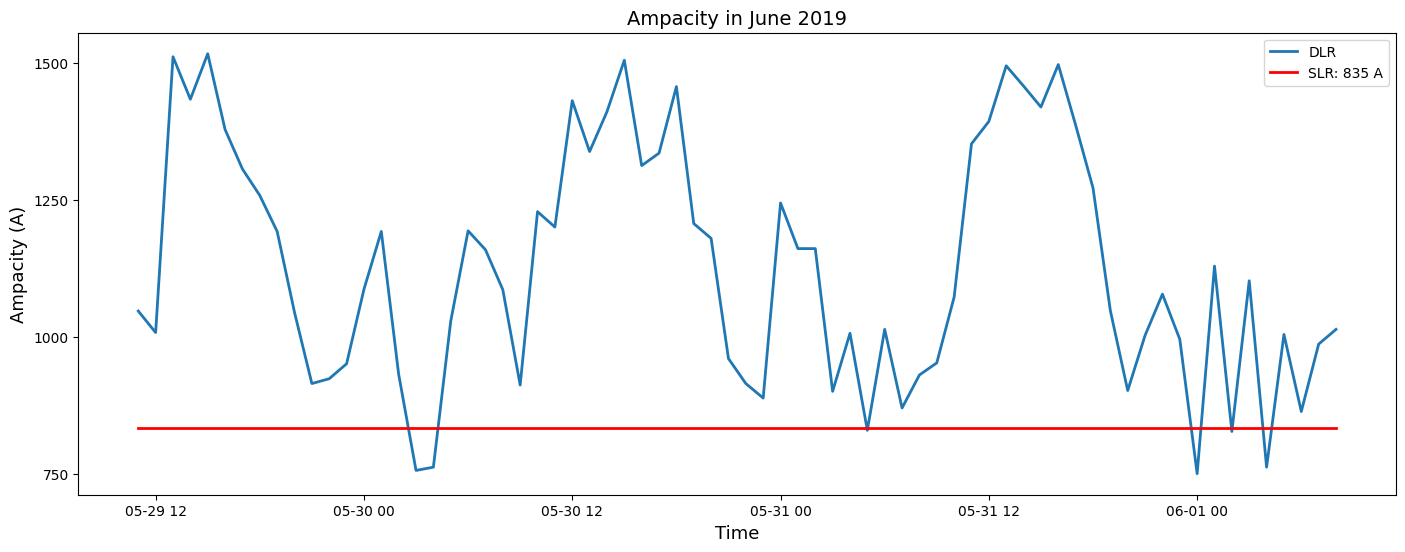

In [110]:
fig = plt.figure(figsize=(17,6))
plt.plot(time,amp_plot,linewidth=2,label ='DLR')
#plt.plot(Wv,[I_CI(25,1000,Wvi,90) for Wvi in Wv],color='blue',linewidth=3)
#plt.plot(Wv,[I_LI(25,1000,Wvi,90) for Wvi in Wv],color='green',linewidth=3)
#ax.set_xticks(range(0,11,1))
#ax.set_xticklabels(range(0,11,1))
yx = plt.subplot()
yx.set_yticks(range(250,2750,250))
yx.set_yticklabels(range(250,2750,250))
plt.ylabel('Ampacity (A)',fontsize=13)
plt.xlabel('Time',fontsize=13)
plt.title('Ampacity in June 2019',fontsize=14)
x = np.linspace(0,11,100)
y = [835 for i in time]
plt.plot(time,y,color='red',linewidth=2,label ='SLR: 835 A')
plt.legend()
plt.show()



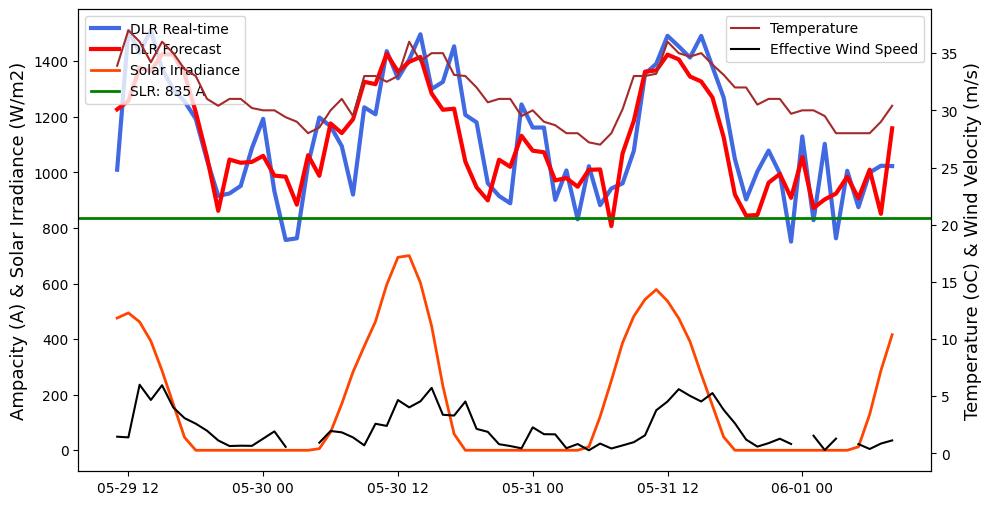

In [111]:
fig,ax = plt.subplots(figsize=(11,6))
ax.plot(time, df.Real,color='royalblue', linewidth=3,label='DLR Real-time')
ax.plot(time, df.Forecast,color='r', linewidth = 3, label = 'DLR Forecast')
ax.plot(time,df.GHI_real, linewidth=2,label='Solar Irradiance',color='orangered')
#ax.set_xlabel("Time",fontsize=13)
ax.set_ylabel("Ampacity (A) & Solar Irradiance (W/m2)",fontsize=13)
#ax.set_yticks(range(250,1750,250))
#ax.set_yticklabels(range(250,1750,250),fontsize=12.5)
plt.legend(loc='upper left',fontsize=12)
#x = np.linspace(0,11,100)
plt.axhline(y=835, color='green',linewidth=2,label='SLR: 835 A')
plt.legend(loc='upper left',fontsize=10)
ax2=ax.twinx()
ax2.plot(time,df.temp_real,linewidth=1.5,color='brown',label='Temperature')
ax2.plot(time,Wve,linewidth=1.5,color='black',label='Effective Wind Speed')
ax2.set_ylabel("Temperature (oC) & Wind Velocity (m/s)",fontsize=13)
plt.xticks(fontsize=12.5)
plt.legend(loc='upper right',fontsize=10)
#plt.savefig(r"D:\USTH\DLR\image\DLR_forecast+real.eps", format='eps', dpi=1500)
plt.show()